In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import zipfile

with zipfile.ZipFile("//content/drive/MyDrive/class40.zip", "r") as zip_ref:
    zip_ref.extractall("./")

# **Adagrad Optimizer batch Size 64**

Epoch 1/10
262/262 [==============================] - ETA: 0s - loss: 3.2468 - accuracy: 0.1743
Epoch 1: val_accuracy improved from -inf to 0.55215, saving model to best_model.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


262/262 [==============================] - 66s 170ms/step - loss: 3.2468 - accuracy: 0.1743 - val_loss: 2.3446 - val_accuracy: 0.5521
Epoch 2/10
262/262 [==============================] - ETA: 0s - loss: 1.8136 - accuracy: 0.5362
Epoch 2: val_accuracy improved from 0.55215 to 0.78193, saving model to best_model.h5
262/262 [==============================] - 41s 155ms/step - loss: 1.8136 - accuracy: 0.5362 - val_loss: 0.9730 - val_accuracy: 0.7819
Epoch 3/10
262/262 [==============================] - ETA: 0s - loss: 1.1333 - accuracy: 0.6984
Epoch 3: val_accuracy improved from 0.78193 to 0.88107, saving model to best_model.h5
262/262 [==============================] - 40s 153ms/step - loss: 1.1333 - accuracy: 0.6984 - val_loss: 0.5982 - val_accuracy: 0.8811
Epoch 4/10
262/262 [==============================] - ETA: 0s - loss: 0.8656 - accuracy: 0.7667
Epoch 4: val_accuracy improved from 0.88107 to 0.92331, saving model to best_model.h5
262/262 [==============================] - 40s 154ms

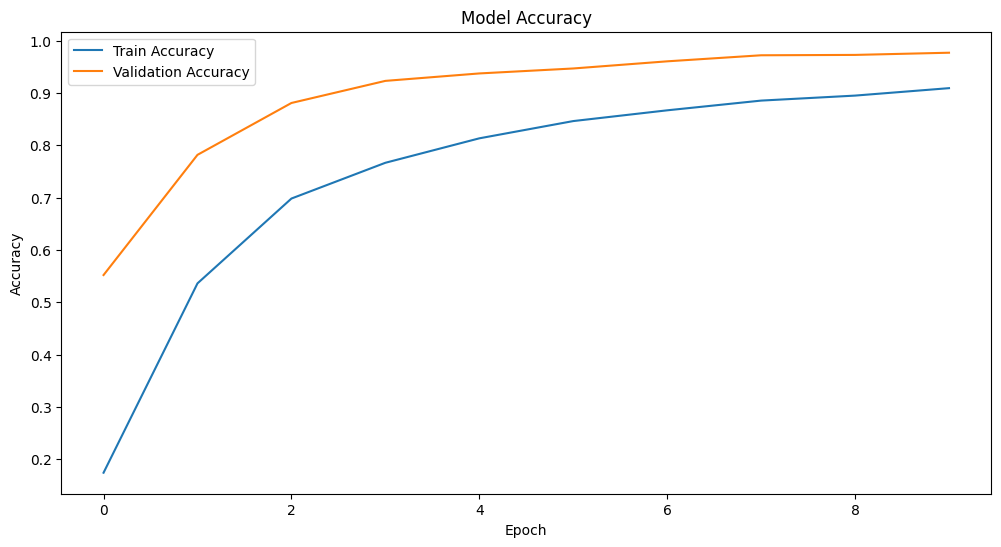

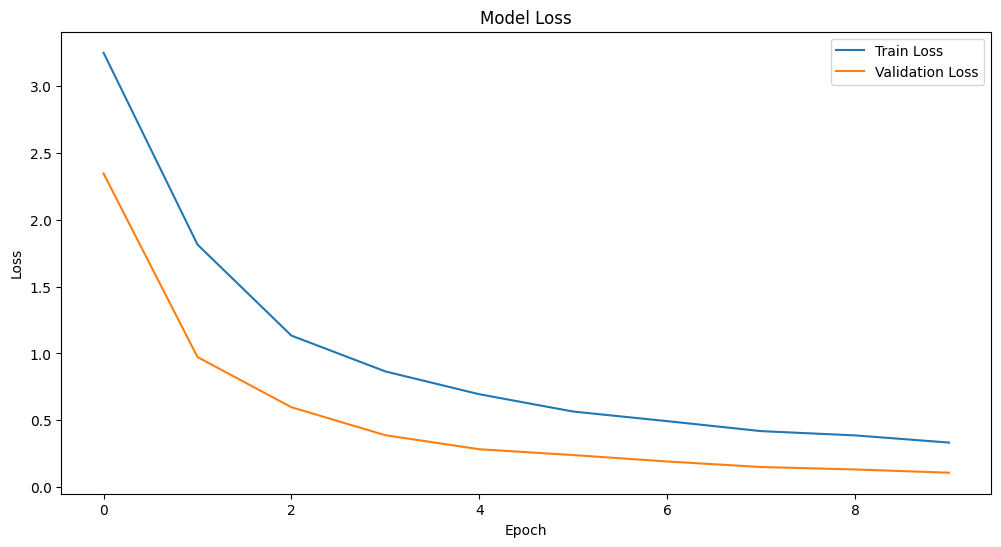

225/225 [==============================] - 6s 22ms/step - loss: 0.1089 - accuracy: 0.9771
Test Loss: 0.10892126709222794
Test Accuracy: 0.9771332740783691
225/225 [==============================] - 5s 21ms/step
F1 Score: 0.974150070813798


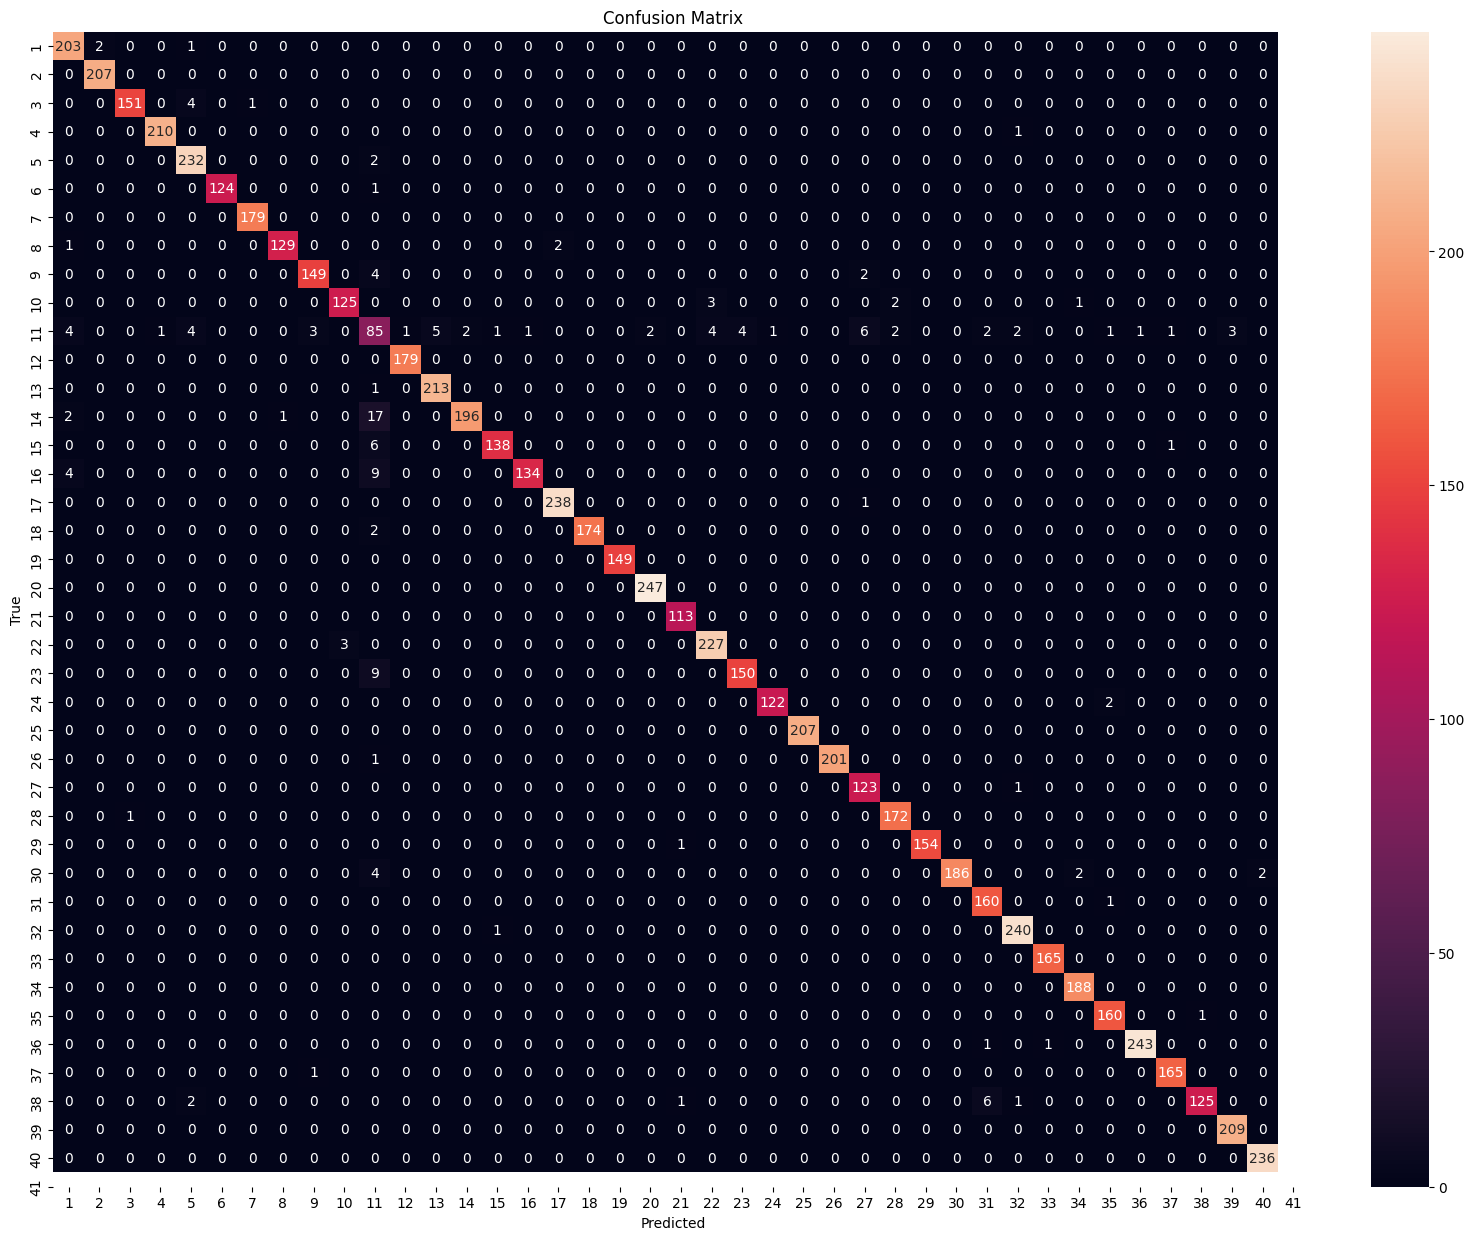

Classification Report:
              precision    recall  f1-score   support

           1       0.95      0.99      0.97       206
           2       0.99      1.00      1.00       207
           3       0.99      0.97      0.98       156
           4       1.00      1.00      1.00       211
           5       0.95      0.99      0.97       234
           6       1.00      0.99      1.00       125
           7       0.99      1.00      1.00       179
           8       0.99      0.98      0.98       132
           9       0.97      0.96      0.97       155
          10       0.98      0.95      0.97       131
          11       0.60      0.62      0.61       136
          12       0.99      1.00      1.00       179
          13       0.98      1.00      0.99       214
          14       0.99      0.91      0.95       216
          15       0.99      0.95      0.97       145
          16       0.99      0.91      0.95       147
          17       0.99      1.00      0.99       239
    

In [ ]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
from keras.applications import Xception
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D, Dropout, Conv2D, MaxPooling2D, Flatten, Input
from keras.optimizers import Adagrad
from keras.callbacks import ModelCheckpoint
from sklearn.metrics import f1_score, classification_report, confusion_matrix, roc_curve, auc
import seaborn as sns
from keras.layers import concatenate

dataset_dir = '/content/class40'


images = []
labels = []

for class_folder in os.listdir(dataset_dir):
   
    label = int(class_folder)


    for image_name in os.listdir(os.path.join(dataset_dir, class_folder)):
              image = cv2.imread(os.path.join(dataset_dir, class_folder, image_name), cv2.IMREAD_COLOR)
     
        image = cv2.resize(image, (71, 71))
     
        image = image.astype('float32') / 255.0
       
        images.append(image)
        labels.append(label)


images = np.array(images)
labels = np.array(labels)

x_train, x_test, y_train, y_test = train_test_split(images, labels, test_size=0.3, random_state=42)

num_classes = 41
y_train_encoded = to_categorical(y_train, num_classes)
y_test_encoded = to_categorical(y_test, num_classes)

def create_model():
    
    cnn_input = Input(shape=(71, 71, 3))
    cnn_conv1 = Conv2D(32, kernel_size=(3, 3), activation='relu')(cnn_input)
    cnn_pool1 = MaxPooling2D(pool_size=(2, 2))(cnn_conv1)
    cnn_conv2 = Conv2D(64, kernel_size=(3, 3), activation='relu')(cnn_pool1)
    cnn_pool2 = MaxPooling2D(pool_size=(2, 2))(cnn_conv2)
    cnn_flatten = Flatten()(cnn_pool2)

   
    base_model = Xception(weights='imagenet', include_top=False, input_shape=(71, 71, 3))
    xception_output = GlobalAveragePooling2D()(base_model.output)


    merged_output = concatenate([cnn_flatten, xception_output])

    x = Dense(128, activation='relu')(merged_output)
    x = Dropout(0.5)(x)
    predictions = Dense(num_classes, activation='softmax')(x)

  
    model = Model(inputs=[cnn_input, base_model.input], outputs=predictions)

    return model


model = create_model()


model.compile(optimizer=Adagrad(lr=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
checkpoint = ModelCheckpoint('best_model.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)
history = model.fit([x_train, x_train], y_train_encoded,
                    batch_size=64,
                    epochs=10,
                    validation_data=([x_test, x_test], y_test_encoded),
                    callbacks=[checkpoint])

# Plot training and validation accuracy
plt.figure(figsize=(12, 6))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot training and validation loss
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Evaluate the model
test_loss, test_accuracy = model.evaluate([x_test, x_test], y_test_encoded)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

# Make predictions
predictions = model.predict([x_test, x_test])
predicted_classes = np.argmax(predictions, axis=1)

# Calculate F1 score
f1 = f1_score(y_test, predicted_classes, average='macro')
print("F1 Score:", f1)

# Calculate confusion matrix
cm = confusion_matrix(y_test, predicted_classes)

plt.figure(figsize=(20, 15))
sns.heatmap(cm, annot=True, fmt="d", xticklabels=np.arange(1, 42), yticklabels=np.arange(1, 42))
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Generate classification report
report = classification_report(y_test, predicted_classes)
print("Classification Report:")
print(report)


# optimizer adagrad batch size 128

83683744/83683744 [==============================] - 4s 0us/step


Epoch 1/10
131/131 [==============================] - ETA: 0s - loss: 3.6071 - accuracy: 0.0801
Epoch 1: val_accuracy improved from -inf to 0.17136, saving model to best_model.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


131/131 [==============================] - 70s 354ms/step - loss: 3.6071 - accuracy: 0.0801 - val_loss: 3.4517 - val_accuracy: 0.1714
Epoch 2/10
131/131 [==============================] - ETA: 0s - loss: 2.9337 - accuracy: 0.2876
Epoch 2: val_accuracy improved from 0.17136 to 0.60360, saving model to best_model.h5
131/131 [==============================] - 38s 290ms/step - loss: 2.9337 - accuracy: 0.2876 - val_loss: 2.2112 - val_accuracy: 0.6036
Epoch 3/10
131/131 [==============================] - ETA: 0s - loss: 1.8088 - accuracy: 0.5536
Epoch 3: val_accuracy improved from 0.60360 to 0.76757, saving model to best_model.h5
131/131 [==============================] - 39s 295ms/step - loss: 1.8088 - accuracy: 0.5536 - val_loss: 1.2077 - val_accuracy: 0.7676
Epoch 4/10
131/131 [==============================] - ETA: 0s - loss: 1.1693 - accuracy: 0.7040
Epoch 4: val_accuracy improved from 0.76757 to 0.80577, saving model to best_model.h5
131/131 [==============================] - 39s 300ms

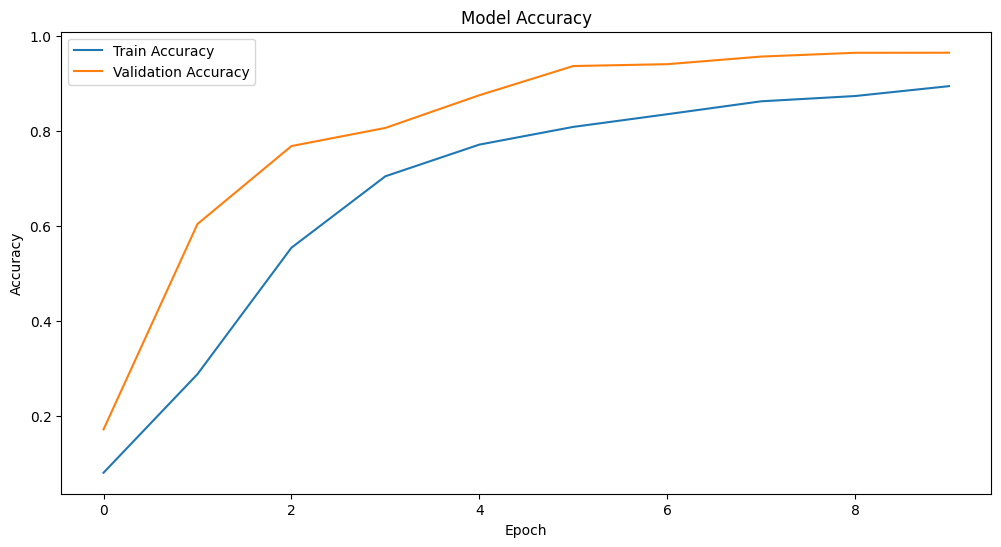

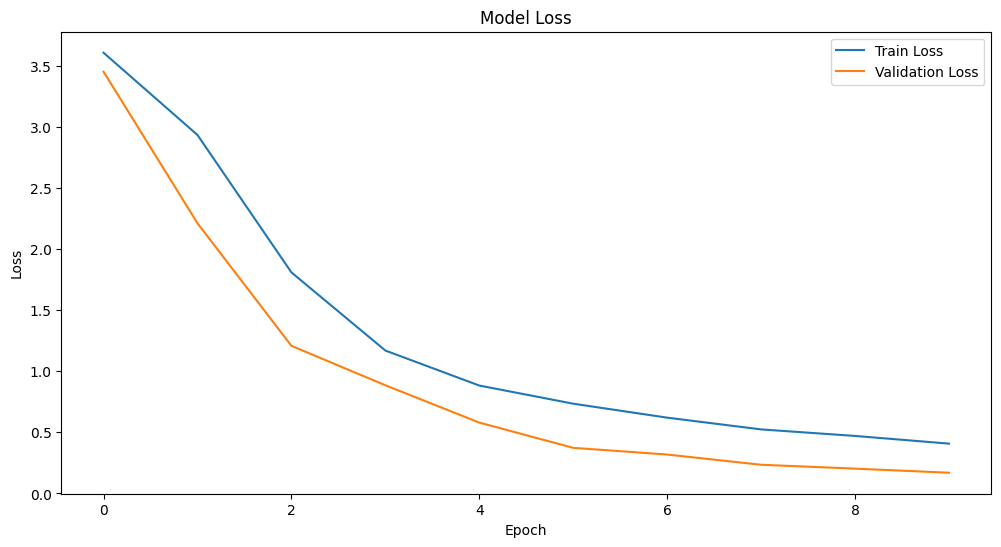

225/225 [==============================] - 7s 24ms/step - loss: 0.1692 - accuracy: 0.9640
Test Loss: 0.1692078858613968
Test Accuracy: 0.9640267491340637
225/225 [==============================] - 6s 23ms/step
F1 Score: 0.9624161728341949


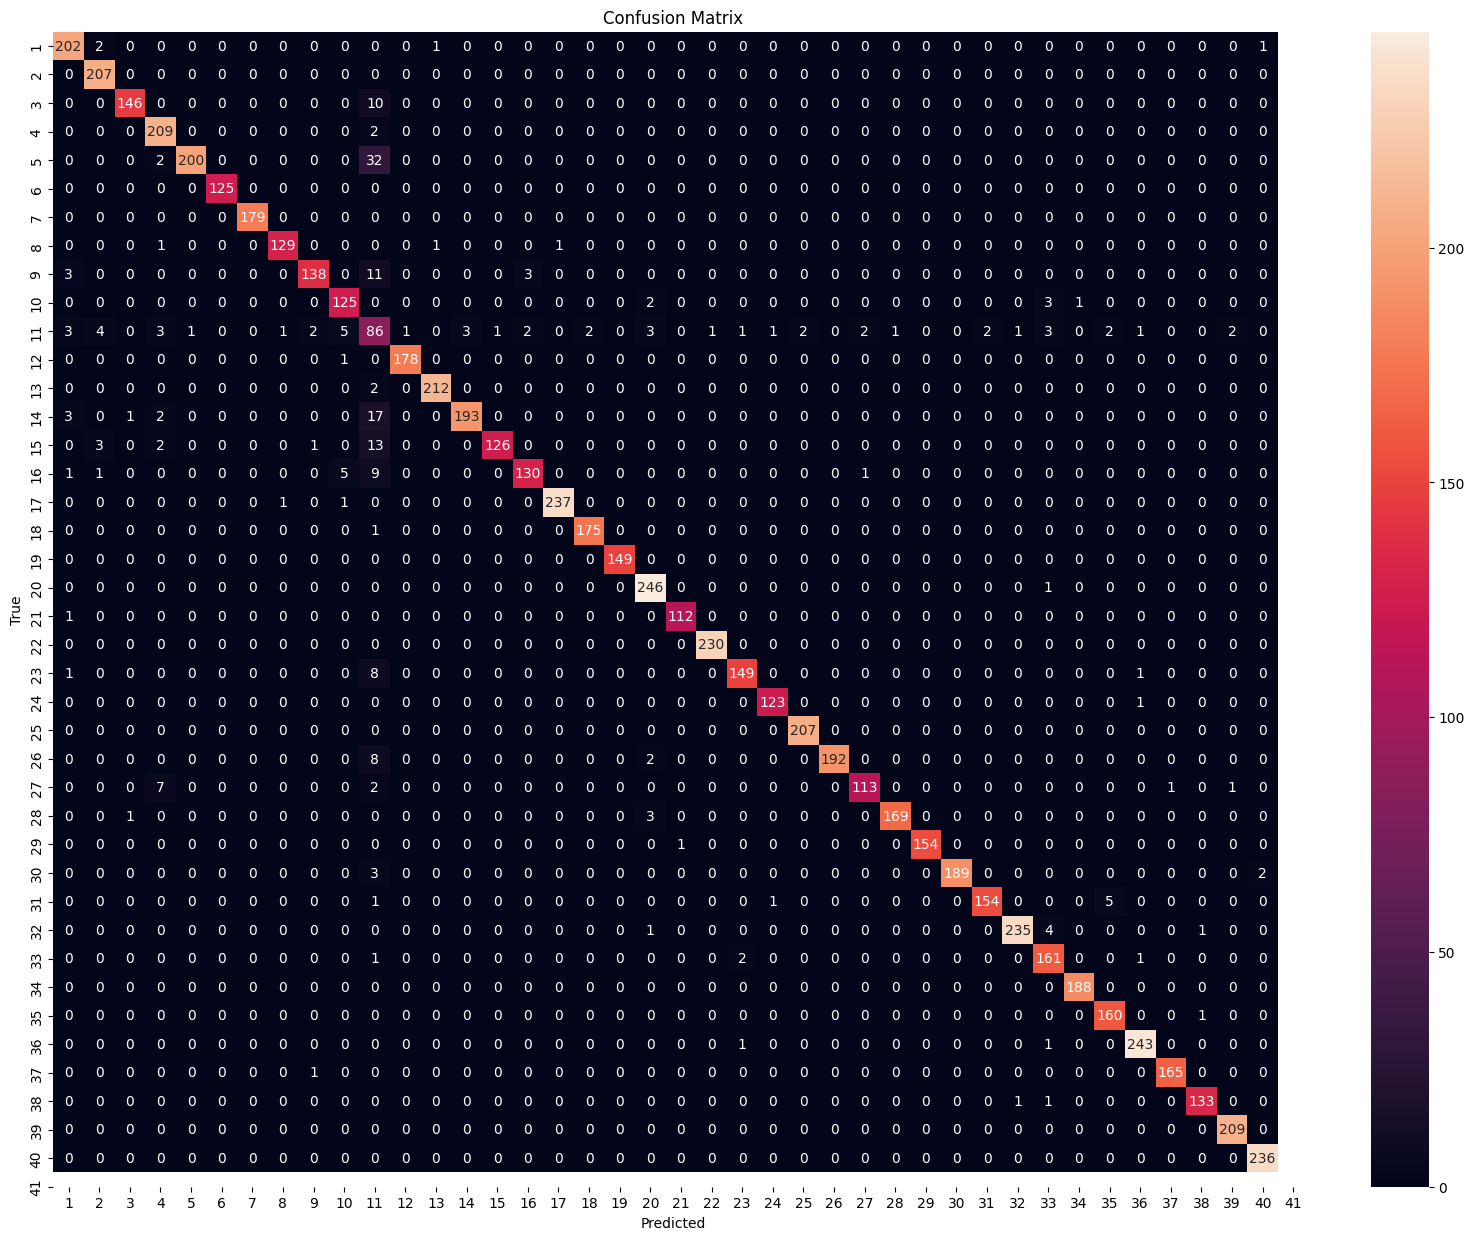

Classification Report:
              precision    recall  f1-score   support

           1       0.94      0.98      0.96       206
           2       0.95      1.00      0.98       207
           3       0.99      0.94      0.96       156
           4       0.92      0.99      0.96       211
           5       1.00      0.85      0.92       234
           6       1.00      1.00      1.00       125
           7       1.00      1.00      1.00       179
           8       0.98      0.98      0.98       132
           9       0.97      0.89      0.93       155
          10       0.91      0.95      0.93       131
          11       0.42      0.63      0.50       136
          12       0.99      0.99      0.99       179
          13       0.99      0.99      0.99       214
          14       0.98      0.89      0.94       216
          15       0.99      0.87      0.93       145
          16       0.96      0.88      0.92       147
          17       1.00      0.99      0.99       239
    

In [ ]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
from keras.applications import Xception
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D, Dropout, Conv2D, MaxPooling2D, Flatten, Input
from keras.optimizers import Adagrad
from keras.callbacks import ModelCheckpoint
from sklearn.metrics import f1_score, classification_report, confusion_matrix, roc_curve, auc
import seaborn as sns
from keras.layers import concatenate

# Directory containing the dataset
dataset_dir = '/content/class40'

# Initialize lists to store images and labels
images = []
labels = []

# Loop through each class folder
for class_folder in os.listdir(dataset_dir):
    # Get the class label from the folder name
    label = int(class_folder)

    # Loop through each image in the class folder
    for image_name in os.listdir(os.path.join(dataset_dir, class_folder)):
        # Read the image
        image = cv2.imread(os.path.join(dataset_dir, class_folder, image_name), cv2.IMREAD_COLOR)
        # Resize the image to a suitable size for Xception (e.g., 71x71)
        image = cv2.resize(image, (80, 80))
        # Normalize pixel values to be between 0 and 1
        image = image.astype('float32') / 255.0
        # Append the image and label to the lists
        images.append(image)
        labels.append(label)

# Convert lists to numpy arrays
images = np.array(images)
labels = np.array(labels)

# Split the dataset into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(images, labels, test_size=0.3, random_state=42)

# One-hot encode the labels
num_classes = 41
y_train_encoded = to_categorical(y_train, num_classes)
y_test_encoded = to_categorical(y_test, num_classes)

# Define CNN-Xception hybrid model
def create_model():
    # Step 1: Define CNN model
    cnn_input = Input(shape=(80, 80, 3))
    cnn_conv1 = Conv2D(32, kernel_size=(3, 3), activation='relu')(cnn_input)
    cnn_pool1 = MaxPooling2D(pool_size=(2, 2))(cnn_conv1)
    cnn_conv2 = Conv2D(64, kernel_size=(3, 3), activation='relu')(cnn_pool1)
    cnn_pool2 = MaxPooling2D(pool_size=(2, 2))(cnn_conv2)
    cnn_flatten = Flatten()(cnn_pool2)

    # Step 2: Load pre-trained Xception model without fully connected layers
    base_model = Xception(weights='imagenet', include_top=False, input_shape=(80, 80, 3))
    xception_output = GlobalAveragePooling2D()(base_model.output)

    # Step 3: Concatenate CNN and Xception outputs
    merged_output = concatenate([cnn_flatten, xception_output])

    # Step 4: Add custom classification layers with dropout
    x = Dense(128, activation='relu')(merged_output)
    x = Dropout(0.5)(x)
    predictions = Dense(num_classes, activation='softmax')(x)

    # Step 5: Create the final model
    model = Model(inputs=[cnn_input, base_model.input], outputs=predictions)

    return model

# Create the model
model = create_model()

# Compile the model with Adagrad optimizer
model.compile(optimizer=Adagrad(lr=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
checkpoint = ModelCheckpoint('best_model.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)
history = model.fit([x_train, x_train], y_train_encoded,
                    batch_size=128,
                    epochs=10,
                    validation_data=([x_test, x_test], y_test_encoded),
                    callbacks=[checkpoint])

# Plot training and validation accuracy
plt.figure(figsize=(12, 6))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot training and validation loss
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Evaluate the model
test_loss, test_accuracy = model.evaluate([x_test, x_test], y_test_encoded)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

# Make predictions
predictions = model.predict([x_test, x_test])
predicted_classes = np.argmax(predictions, axis=1)

# Calculate F1 score
f1 = f1_score(y_test, predicted_classes, average='macro')
print("F1 Score:", f1)

# Calculate confusion matrix
cm = confusion_matrix(y_test, predicted_classes)

# Plot confusion matrix with class labels starting from 1
plt.figure(figsize=(20, 15))
sns.heatmap(cm, annot=True, fmt="d", xticklabels=np.arange(1, 42), yticklabels=np.arange(1, 42))
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Generate classification report
report = classification_report(y_test, predicted_classes)
print("Classification Report:")
print(report)


# adagrad optimizer batch size 32

Epoch 1/10
523/523 [==============================] - ETA: 0s - loss: 2.4791 - accuracy: 0.3748
Epoch 1: val_accuracy improved from -inf to 0.78737, saving model to best_model.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


523/523 [==============================] - 68s 102ms/step - loss: 2.4791 - accuracy: 0.3748 - val_loss: 1.0654 - val_accuracy: 0.7874
Epoch 2/10
523/523 [==============================] - ETA: 0s - loss: 1.0633 - accuracy: 0.7187
Epoch 2: val_accuracy improved from 0.78737 to 0.91272, saving model to best_model.h5
523/523 [==============================] - 48s 92ms/step - loss: 1.0633 - accuracy: 0.7187 - val_loss: 0.5683 - val_accuracy: 0.9127
Epoch 3/10
523/523 [==============================] - ETA: 0s - loss: 0.6828 - accuracy: 0.8152
Epoch 3: val_accuracy improved from 0.91272 to 0.94855, saving model to best_model.h5
523/523 [==============================] - 49s 94ms/step - loss: 0.6828 - accuracy: 0.8152 - val_loss: 0.2847 - val_accuracy: 0.9485
Epoch 4/10
523/523 [==============================] - ETA: 0s - loss: 0.5164 - accuracy: 0.8601
Epoch 4: val_accuracy improved from 0.94855 to 0.96640, saving model to best_model.h5
523/523 [==============================] - 49s 94ms/st

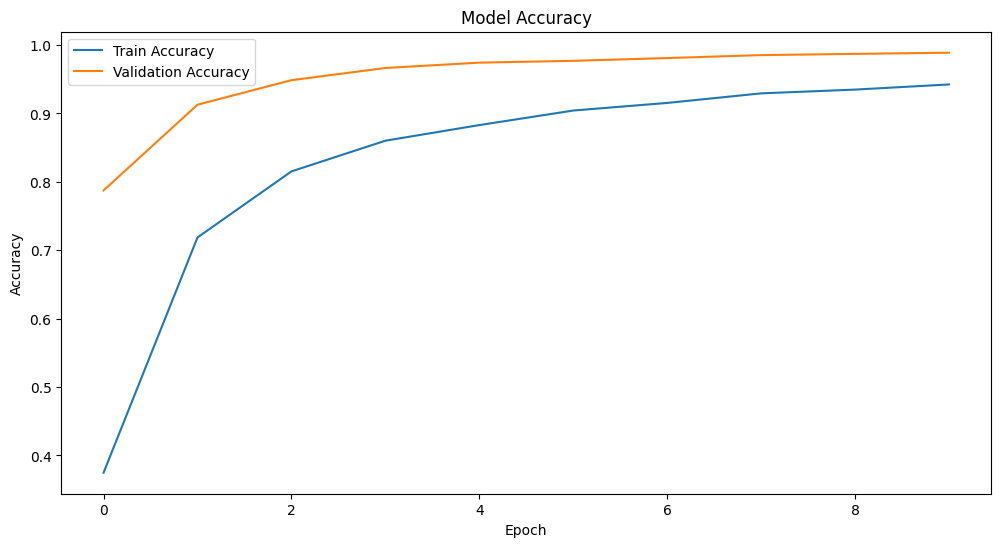

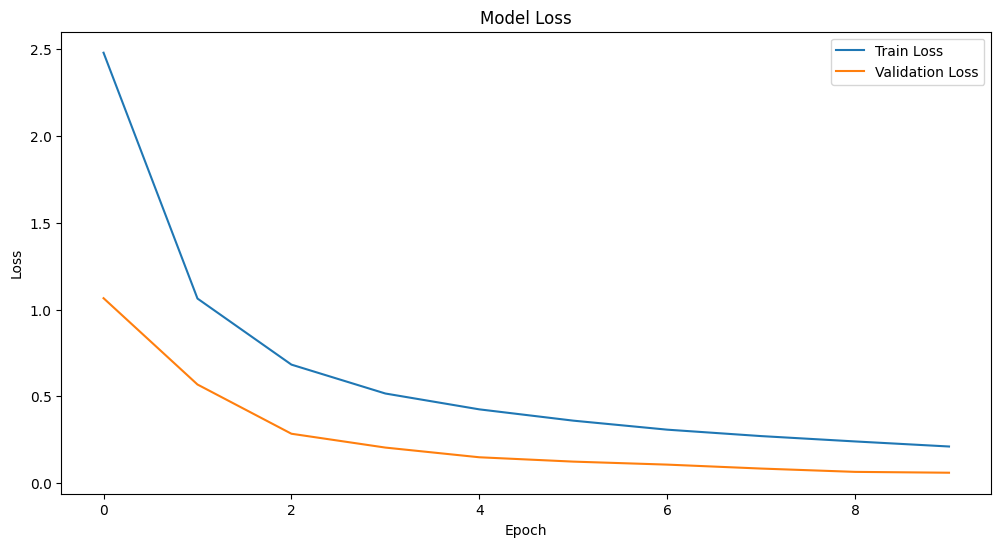

225/225 [==============================] - 5s 24ms/step - loss: 0.0602 - accuracy: 0.9887
Test Loss: 0.060215726494789124
Test Accuracy: 0.9887060523033142
225/225 [==============================] - 6s 22ms/step
F1 Score: 0.9862824758785486


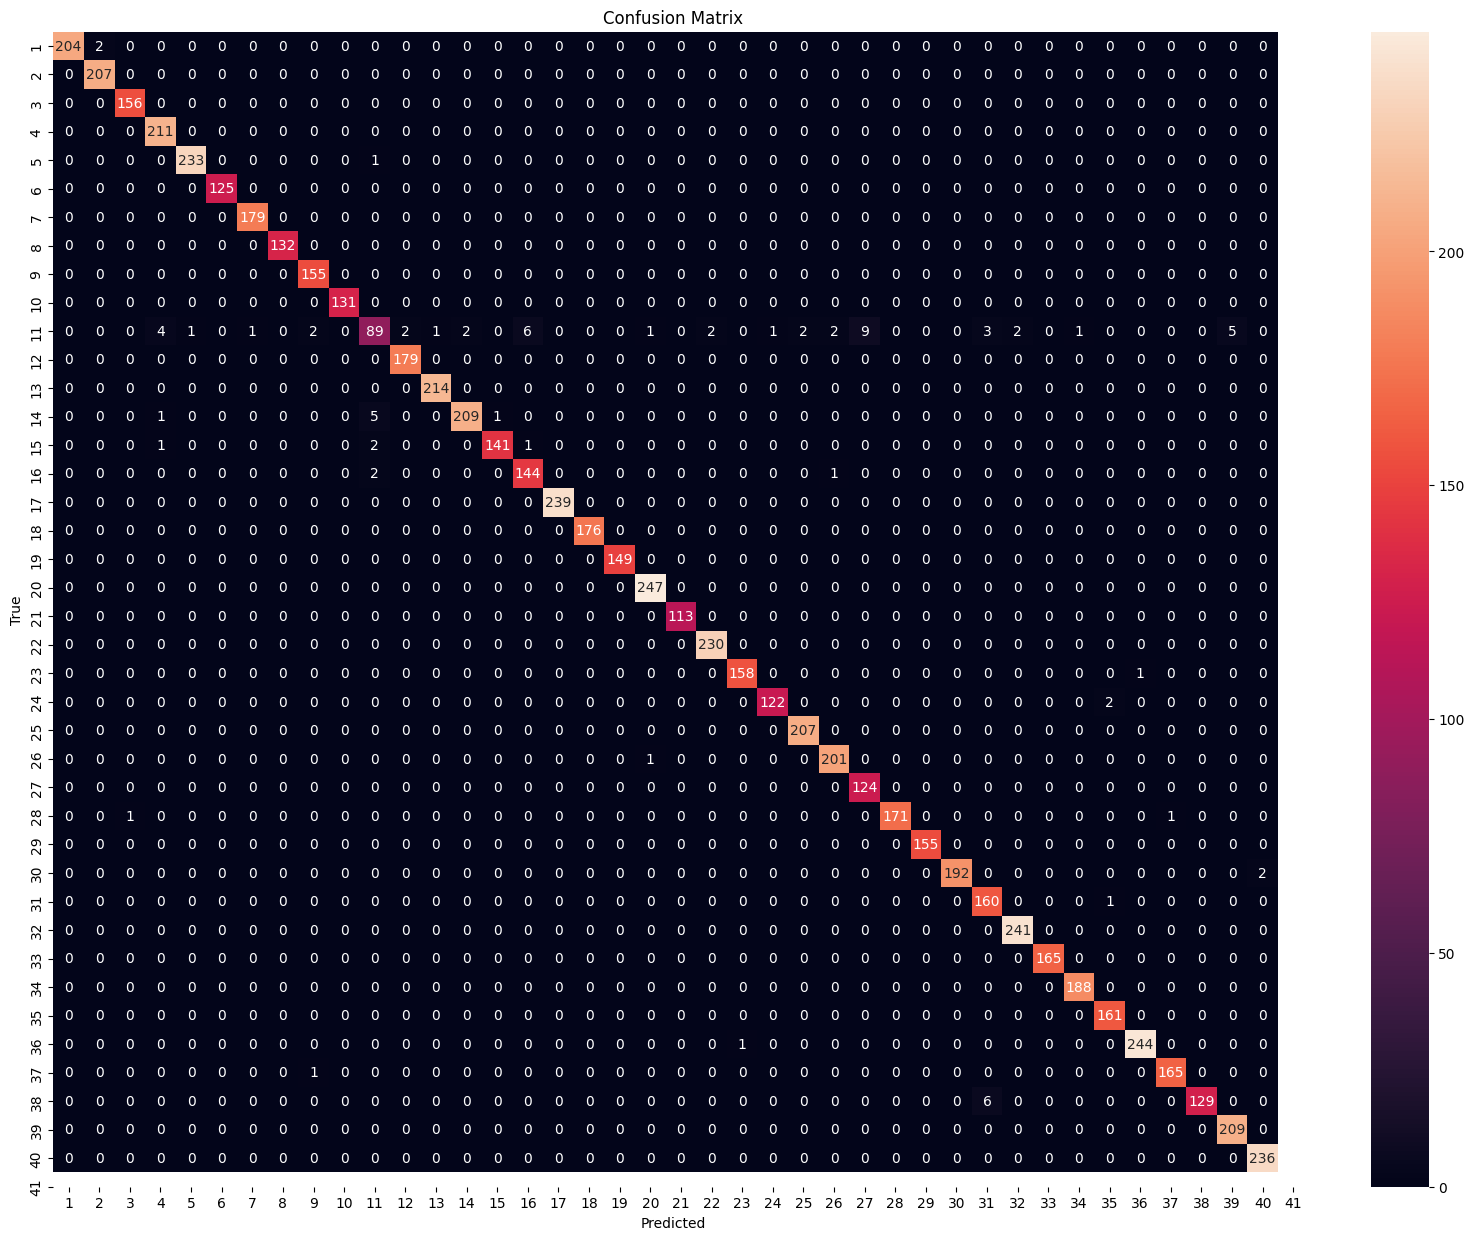

Classification Report:
              precision    recall  f1-score   support

           1       1.00      0.99      1.00       206
           2       0.99      1.00      1.00       207
           3       0.99      1.00      1.00       156
           4       0.97      1.00      0.99       211
           5       1.00      1.00      1.00       234
           6       1.00      1.00      1.00       125
           7       0.99      1.00      1.00       179
           8       1.00      1.00      1.00       132
           9       0.98      1.00      0.99       155
          10       1.00      1.00      1.00       131
          11       0.90      0.65      0.76       136
          12       0.99      1.00      0.99       179
          13       1.00      1.00      1.00       214
          14       0.99      0.97      0.98       216
          15       0.99      0.97      0.98       145
          16       0.95      0.98      0.97       147
          17       1.00      1.00      1.00       239
    

In [ ]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
from keras.applications import Xception
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D, Dropout, Conv2D, MaxPooling2D, Flatten, Input
from keras.optimizers import Adagrad
from keras.callbacks import ModelCheckpoint
from sklearn.metrics import f1_score, classification_report, confusion_matrix, roc_curve, auc
import seaborn as sns
from keras.layers import concatenate

# Directory containing the dataset
dataset_dir = '/content/class40'

# Initialize lists to store images and labels
images = []
labels = []

# Loop through each class folder
for class_folder in os.listdir(dataset_dir):
    # Get the class label from the folder name
    label = int(class_folder)

    # Loop through each image in the class folder
    for image_name in os.listdir(os.path.join(dataset_dir, class_folder)):
        # Read the image
        image = cv2.imread(os.path.join(dataset_dir, class_folder, image_name), cv2.IMREAD_COLOR)
        # Resize the image to a suitable size for Xception (e.g., 71x71)
        image = cv2.resize(image, (80, 80))
        # Normalize pixel values to be between 0 and 1
        image = image.astype('float32') / 255.0
        # Append the image and label to the lists
        images.append(image)
        labels.append(label)

# Convert lists to numpy arrays
images = np.array(images)
labels = np.array(labels)

# Split the dataset into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(images, labels, test_size=0.3, random_state=42)

# One-hot encode the labels
num_classes = 41
y_train_encoded = to_categorical(y_train, num_classes)
y_test_encoded = to_categorical(y_test, num_classes)

# Define CNN-Xception hybrid model
def create_model():
    # Step 1: Define CNN model
    cnn_input = Input(shape=(80, 80, 3))
    cnn_conv1 = Conv2D(32, kernel_size=(3, 3), activation='relu')(cnn_input)
    cnn_pool1 = MaxPooling2D(pool_size=(2, 2))(cnn_conv1)
    cnn_conv2 = Conv2D(64, kernel_size=(3, 3), activation='relu')(cnn_pool1)
    cnn_pool2 = MaxPooling2D(pool_size=(2, 2))(cnn_conv2)
    cnn_flatten = Flatten()(cnn_pool2)

    # Step 2: Load pre-trained Xception model without fully connected layers
    base_model = Xception(weights='imagenet', include_top=False, input_shape=(80, 80, 3))
    xception_output = GlobalAveragePooling2D()(base_model.output)

    # Step 3: Concatenate CNN and Xception outputs
    merged_output = concatenate([cnn_flatten, xception_output])

    # Step 4: Add custom classification layers with dropout
    x = Dense(128, activation='relu')(merged_output)
    x = Dropout(0.5)(x)
    predictions = Dense(num_classes, activation='softmax')(x)

    # Step 5: Create the final model
    model = Model(inputs=[cnn_input, base_model.input], outputs=predictions)

    return model

# Create the model
model = create_model()

# Compile the model with Adagrad optimizer
model.compile(optimizer=Adagrad(lr=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
checkpoint = ModelCheckpoint('best_model.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)
history = model.fit([x_train, x_train], y_train_encoded,
                    batch_size=32,
                    epochs=10,
                    validation_data=([x_test, x_test], y_test_encoded),
                    callbacks=[checkpoint])

# Plot training and validation accuracy
plt.figure(figsize=(12, 6))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot training and validation loss
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Evaluate the model
test_loss, test_accuracy = model.evaluate([x_test, x_test], y_test_encoded)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

# Make predictions
predictions = model.predict([x_test, x_test])
predicted_classes = np.argmax(predictions, axis=1)

# Calculate F1 score
f1 = f1_score(y_test, predicted_classes, average='macro')
print("F1 Score:", f1)

# Calculate confusion matrix
cm = confusion_matrix(y_test, predicted_classes)

# Plot confusion matrix with class labels starting from 1
plt.figure(figsize=(20, 15))
sns.heatmap(cm, annot=True, fmt="d", xticklabels=np.arange(1, 42), yticklabels=np.arange(1, 42))
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Generate classification report
report = classification_report(y_test, predicted_classes)
print("Classification Report:")
print(report)


# **ADAM Optimizer Batch Size 32**

Epoch 1/10
523/523 [==============================] - ETA: 0s - loss: 1.9202 - accuracy: 0.4732
Epoch 1: val_accuracy improved from -inf to 0.96458, saving model to best_model_with_dropout.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


523/523 [==============================] - 76s 104ms/step - loss: 1.9202 - accuracy: 0.4732 - val_loss: 0.2754 - val_accuracy: 0.9646
Epoch 2/10
523/523 [==============================] - ETA: 0s - loss: 0.7624 - accuracy: 0.7783
Epoch 2: val_accuracy improved from 0.96458 to 0.98104, saving model to best_model_with_dropout.h5
523/523 [==============================] - 51s 97ms/step - loss: 0.7624 - accuracy: 0.7783 - val_loss: 0.1337 - val_accuracy: 0.9810
Epoch 3/10
523/523 [==============================] - ETA: 0s - loss: 0.5475 - accuracy: 0.8439
Epoch 3: val_accuracy did not improve from 0.98104
523/523 [==============================] - 50s 95ms/step - loss: 0.5475 - accuracy: 0.8439 - val_loss: 0.1525 - val_accuracy: 0.9780
Epoch 4/10
523/523 [==============================] - ETA: 0s - loss: 0.4336 - accuracy: 0.8773
Epoch 4: val_accuracy improved from 0.98104 to 0.99149, saving model to best_model_with_dropout.h5
523/523 [==============================] - 51s 97ms/step - loss

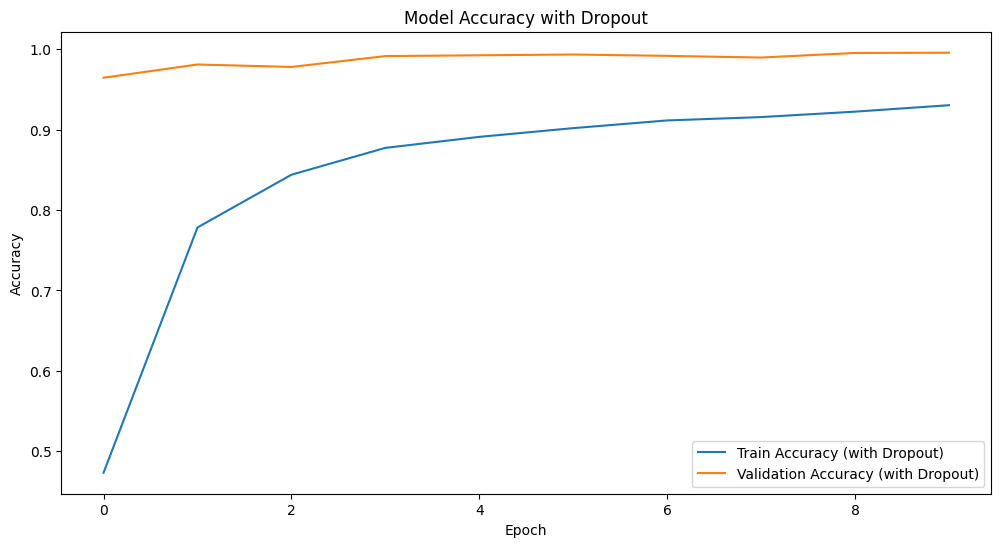

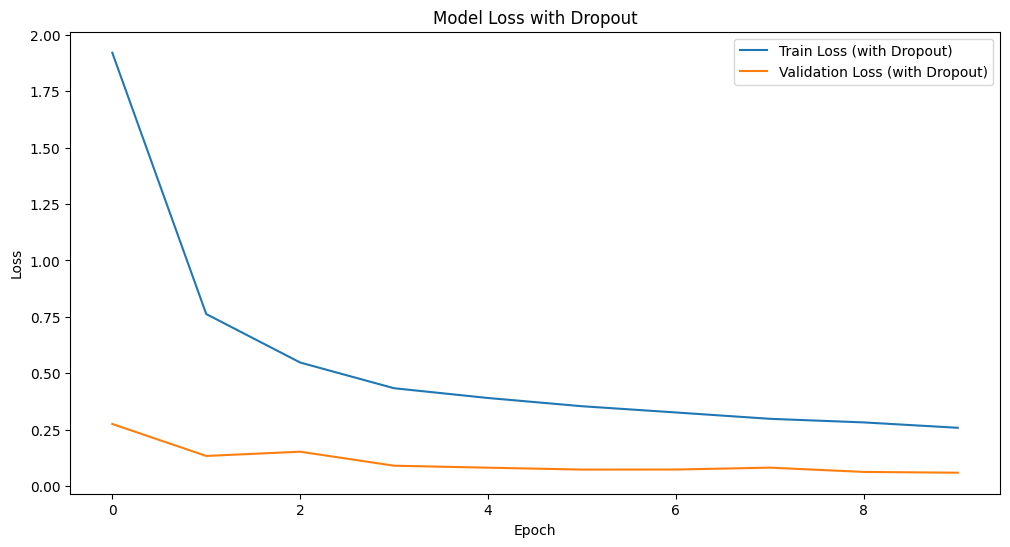

In [ ]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
from keras.applications import Xception
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D, Dropout, Conv2D, MaxPooling2D, Flatten, Input
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint
from sklearn.metrics import f1_score, classification_report, confusion_matrix
import seaborn as sns
from keras.layers import concatenate
from keras.regularizers import l2


dataset_dir = '/content/class40'

images = []
labels = []


for class_folder in os.listdir(dataset_dir):
   
    label = int(class_folder)

    
    for image_name in os.listdir(os.path.join(dataset_dir, class_folder)):
        # Read the image
        image = cv2.imread(os.path.join(dataset_dir, class_folder, image_name), cv2.IMREAD_COLOR)
      
        image = cv2.resize(image, (80, 80))
      
        image = image.astype('float32') / 255.0
       
        images.append(image)
        labels.append(label)


images = np.array(images)
labels = np.array(labels)

# Split the dataset into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(images, labels, test_size=0.3, random_state=42)


num_classes = 41
y_train_encoded = to_categorical(y_train, num_classes)
y_test_encoded = to_categorical(y_test, num_classes)

def create_model_with_dropout():
  
    cnn_input = Input(shape=(80, 80, 3))
    cnn_conv1 = Conv2D(32, kernel_size=(3, 3), activation='relu')(cnn_input)
    cnn_pool1 = MaxPooling2D(pool_size=(2, 2))(cnn_conv1)
    cnn_conv2 = Conv2D(64, kernel_size=(3, 3), activation='relu')(cnn_pool1)
    cnn_pool2 = MaxPooling2D(pool_size=(2, 2))(cnn_conv2)
    cnn_flatten = Flatten()(cnn_pool2)

 
    base_model = Xception(weights='imagenet', include_top=False, input_shape=(80, 80, 3))
    xception_output = GlobalAveragePooling2D()(base_model.output)

    merged_output = concatenate([cnn_flatten, xception_output])


    x = Dense(128, activation='relu')(merged_output)
    x = Dropout(0.5)(x)  
    x = Dense(64, activation='relu', kernel_regularizer=l2(0.001))(x) 
    x = Dropout(0.5)(x)  
    predictions = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=[cnn_input, base_model.input], outputs=predictions)

    return model


model_with_dropout = create_model_with_dropout()

# Compile the model with Adam optimizer
model_with_dropout.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


checkpoint = ModelCheckpoint('best_model_with_dropout.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)
history_dropout = model_with_dropout.fit([x_train, x_train], y_train_encoded,
                                         batch_size=32,
                                         epochs=10,
                                         validation_data=([x_test, x_test], y_test_encoded),
                                         callbacks=[checkpoint])

plt.figure(figsize=(12, 6))
plt.plot(history_dropout.history['accuracy'], label='Train Accuracy (with Dropout)')
plt.plot(history_dropout.history['val_accuracy'], label='Validation Accuracy (with Dropout)')
plt.title('Model Accuracy with Dropout')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

#
plt.figure(figsize=(12, 6))
plt.plot(history_dropout.history['loss'], label='Train Loss (with Dropout)')
plt.plot(history_dropout.history['val_loss'], label='Validation Loss (with Dropout)')
plt.title('Model Loss with Dropout')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


225/225 [==============================] - 5s 23ms/step - loss: 0.0593 - accuracy: 0.9957
Test Loss (with Dropout): 0.0593472421169281
Test Accuracy (with Dropout): 0.995677649974823
225/225 [==============================] - 6s 22ms/step
F1 Score (with Dropout): 0.9949488792552319


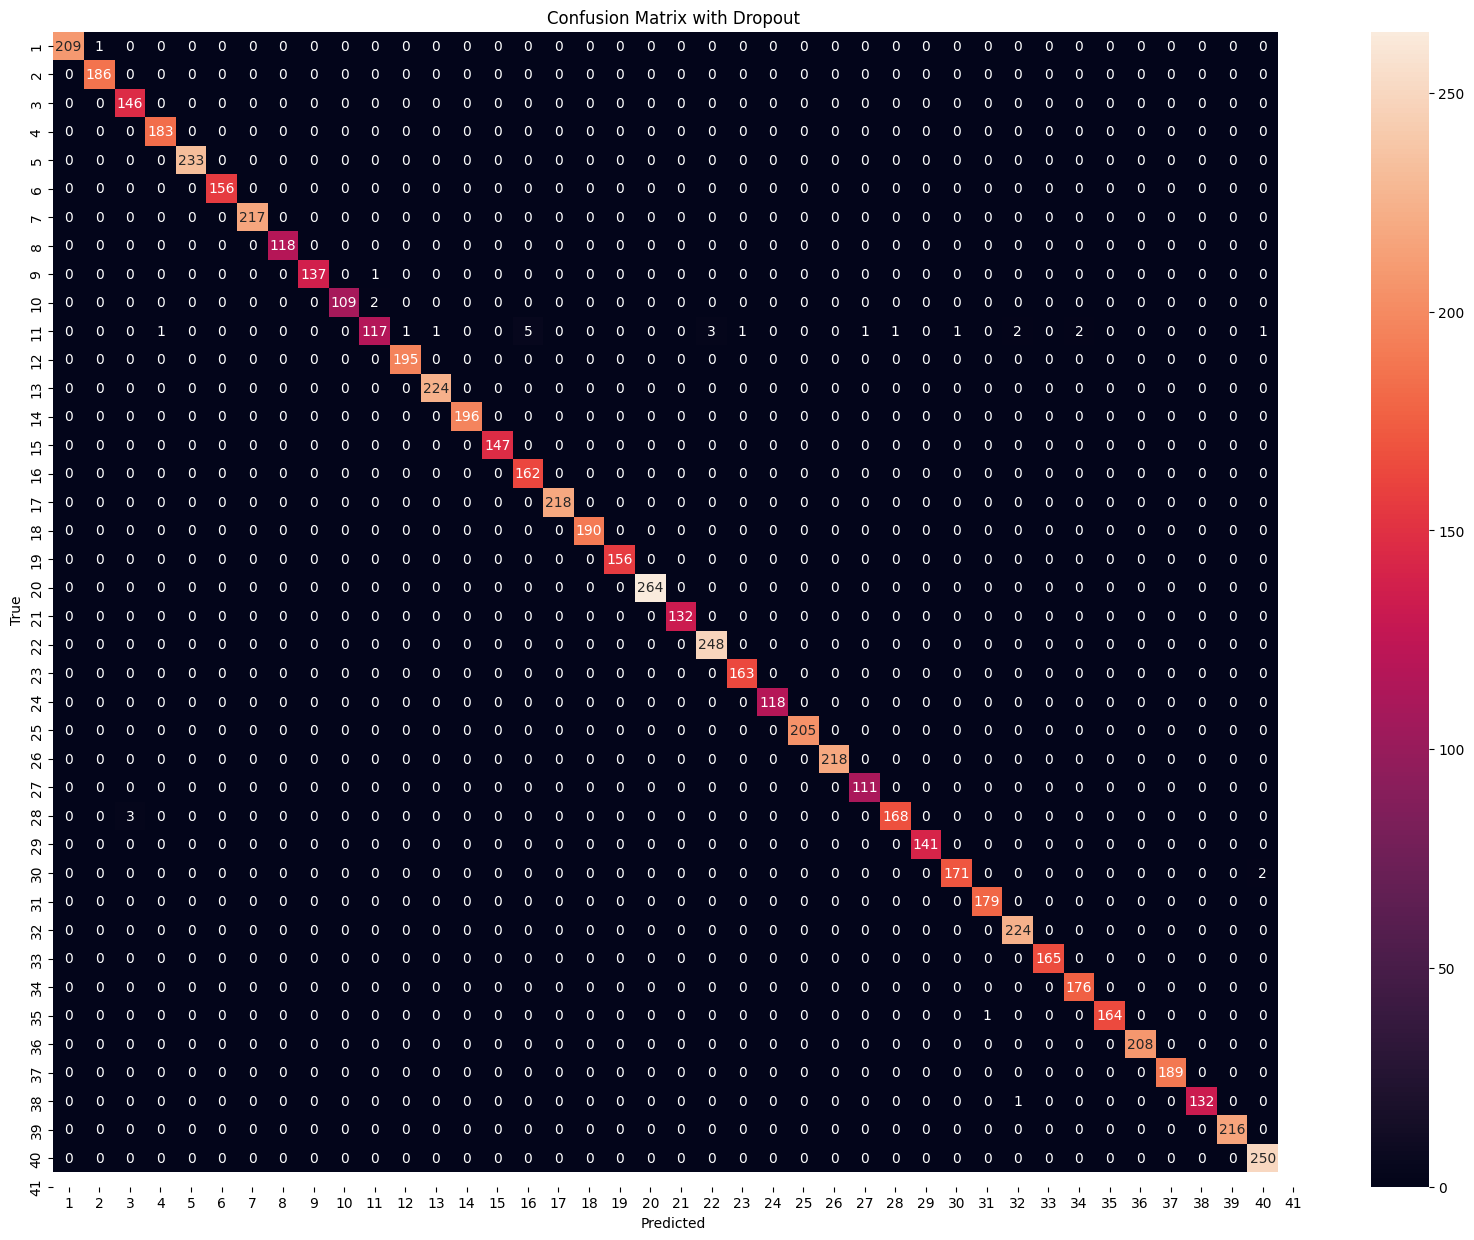

Classification Report (with Dropout):
              precision    recall  f1-score   support

           1       1.00      1.00      1.00       210
           2       0.99      1.00      1.00       186
           3       0.98      1.00      0.99       146
           4       0.99      1.00      1.00       183
           5       1.00      1.00      1.00       233
           6       1.00      1.00      1.00       156
           7       1.00      1.00      1.00       217
           8       1.00      1.00      1.00       118
           9       1.00      0.99      1.00       138
          10       1.00      0.98      0.99       111
          11       0.97      0.85      0.91       137
          12       0.99      1.00      1.00       195
          13       1.00      1.00      1.00       224
          14       1.00      1.00      1.00       196
          15       1.00      1.00      1.00       147
          16       0.97      1.00      0.98       162
          17       1.00      1.00      1.00

In [ ]:

test_loss_dropout, test_accuracy_dropout = model_with_dropout.evaluate([x_test, x_test], y_test_encoded)
print("Test Loss (with Dropout):", test_loss_dropout)
print("Test Accuracy (with Dropout):", test_accuracy_dropout)

predictions_dropout = model_with_dropout.predict([x_test, x_test])
predicted_classes_dropout = np.argmax(predictions_dropout, axis=1)


f1_dropout = f1_score(y_test, predicted_classes_dropout, average='macro')
print("F1 Score (with Dropout):", f1_dropout)


cm_dropout = confusion_matrix(y_test, predicted_classes_dropout)


plt.figure(figsize=(20, 15))
sns.heatmap(cm_dropout, annot=True, fmt="d", xticklabels=np.arange(1, 42), yticklabels=np.arange(1, 42))
plt.title('Confusion Matrix with Dropout')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Generate classification report with dropout
report_dropout = classification_report(y_test, predicted_classes_dropout)
print("Classification Report (with Dropout):")
print(report_dropout)


Epoch 1/10
523/523 [==============================] - ETA: 0s - loss: 0.6555 - accuracy: 0.8247
Epoch 1: val_accuracy improved from -inf to 0.85332, saving model to best_model_with_lower_dropout.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


523/523 [==============================] - 76s 105ms/step - loss: 0.6555 - accuracy: 0.8247 - val_loss: 3.6124 - val_accuracy: 0.8533
Epoch 2/10
523/523 [==============================] - ETA: 0s - loss: 0.1011 - accuracy: 0.9700
Epoch 2: val_accuracy improved from 0.85332 to 0.97867, saving model to best_model_with_lower_dropout.h5
523/523 [==============================] - 51s 97ms/step - loss: 0.1011 - accuracy: 0.9700 - val_loss: 0.2444 - val_accuracy: 0.9787
Epoch 3/10
523/523 [==============================] - ETA: 0s - loss: 0.0700 - accuracy: 0.9787
Epoch 3: val_accuracy improved from 0.97867 to 0.99582, saving model to best_model_with_lower_dropout.h5
523/523 [==============================] - 51s 97ms/step - loss: 0.0700 - accuracy: 0.9787 - val_loss: 0.0189 - val_accuracy: 0.9958
Epoch 4/10
523/523 [==============================] - ETA: 0s - loss: 0.0523 - accuracy: 0.9854
Epoch 4: val_accuracy did not improve from 0.99582
523/523 [==============================] - 50s 95ms

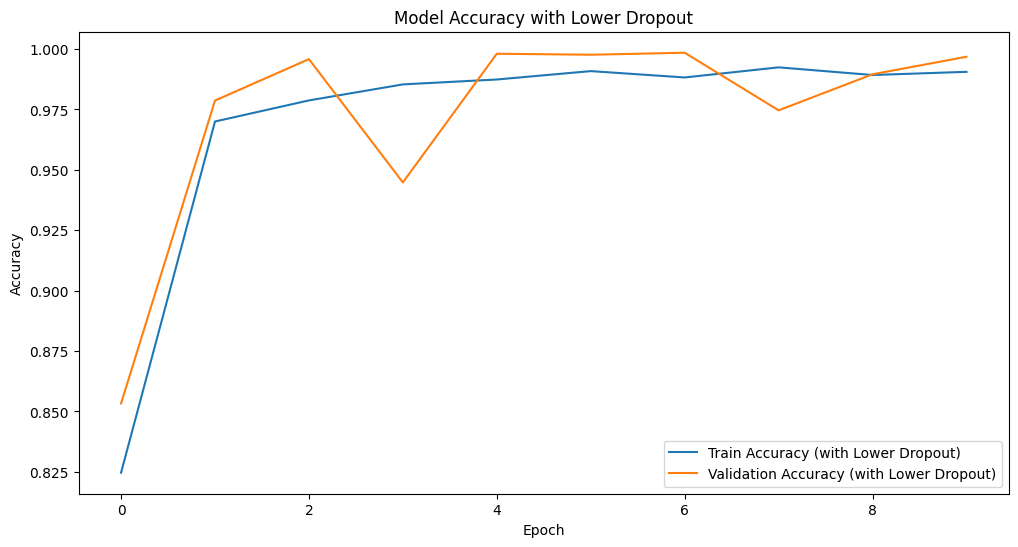

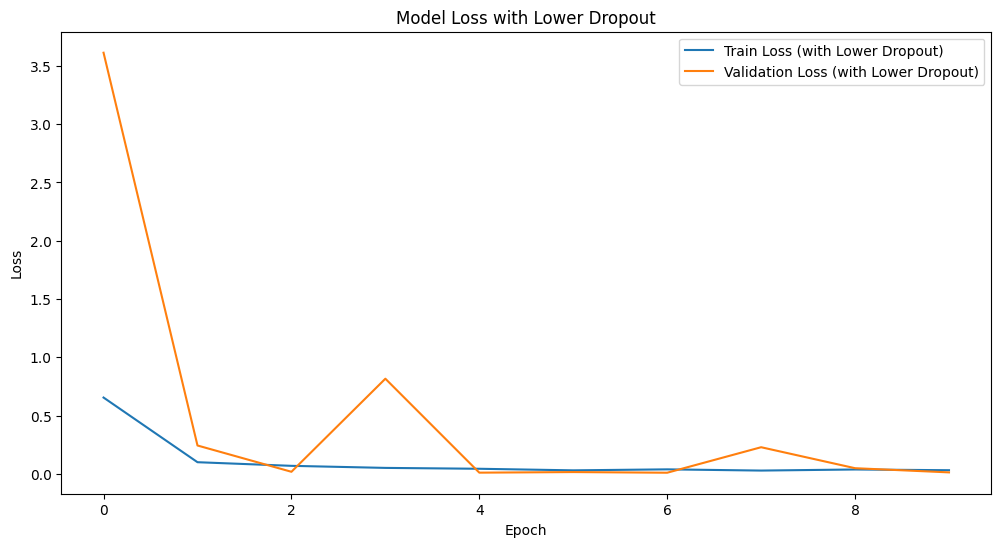

225/225 [==============================] - 5s 24ms/step - loss: 0.0139 - accuracy: 0.9968
Test Loss (with Lower Dropout): 0.01387301366776228
Test Accuracy (with Lower Dropout): 0.9967930912971497
225/225 [==============================] - 6s 22ms/step
F1 Score (with Lower Dropout): 0.9966984612888364


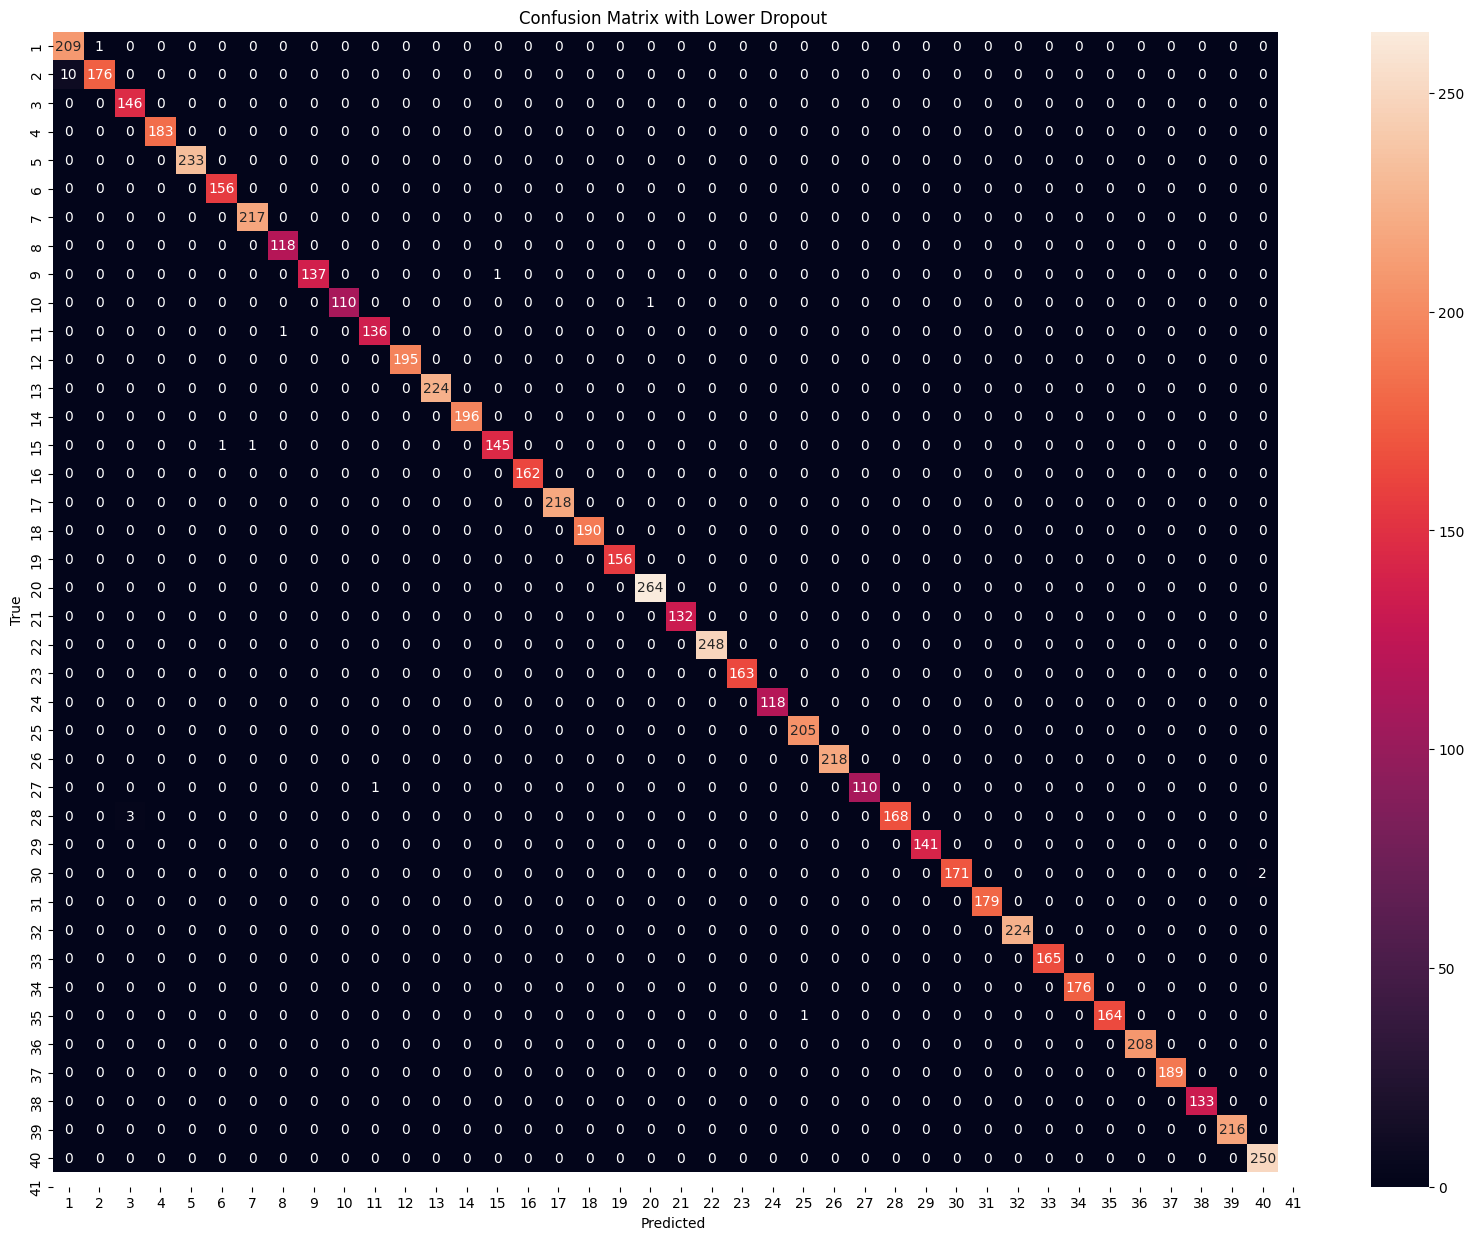

Classification Report (with Lower Dropout):
              precision    recall  f1-score   support

           1       0.95      1.00      0.97       210
           2       0.99      0.95      0.97       186
           3       0.98      1.00      0.99       146
           4       1.00      1.00      1.00       183
           5       1.00      1.00      1.00       233
           6       0.99      1.00      1.00       156
           7       1.00      1.00      1.00       217
           8       0.99      1.00      1.00       118
           9       1.00      0.99      1.00       138
          10       1.00      0.99      1.00       111
          11       0.99      0.99      0.99       137
          12       1.00      1.00      1.00       195
          13       1.00      1.00      1.00       224
          14       1.00      1.00      1.00       196
          15       0.99      0.99      0.99       147
          16       1.00      1.00      1.00       162
          17       1.00      1.00    

In [ ]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
from keras.applications import Xception
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D, Dropout, Conv2D, MaxPooling2D, Flatten, Input
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint
from sklearn.metrics import f1_score, classification_report, confusion_matrix
import seaborn as sns
from keras.layers import concatenate


dataset_dir = '/content/class40'


images = []
labels = []


for class_folder in os.listdir(dataset_dir):
  
    label = int(class_folder)

   
    for image_name in os.listdir(os.path.join(dataset_dir, class_folder)):
       
        image = cv2.imread(os.path.join(dataset_dir, class_folder, image_name), cv2.IMREAD_COLOR)
         image = cv2.resize(image, (80, 80))
       image = image.astype('float32') / 255.0
        images.append(image)
        labels.append(label)


images = np.array(images)
labels = np.array(labels)


x_train, x_test, y_train, y_test = train_test_split(images, labels, test_size=0.3, random_state=42)


num_classes = 41
y_train_encoded = to_categorical(y_train, num_classes)
y_test_encoded = to_categorical(y_test, num_classes)


def create_model_with_lower_dropout():
  
    cnn_input = Input(shape=(80, 80, 3))
    cnn_conv1 = Conv2D(32, kernel_size=(3, 3), activation='relu')(cnn_input)
    cnn_pool1 = MaxPooling2D(pool_size=(2, 2))(cnn_conv1)
    cnn_conv2 = Conv2D(64, kernel_size=(3, 3), activation='relu')(cnn_pool1)
    cnn_pool2 = MaxPooling2D(pool_size=(2, 2))(cnn_conv2)
    cnn_flatten = Flatten()(cnn_pool2)

 
    base_model = Xception(weights='imagenet', include_top=False, input_shape=(80, 80, 3))
    xception_output = GlobalAveragePooling2D()(base_model.output)

   
    merged_output = concatenate([cnn_flatten, xception_output])

 
    x = Dense(128, activation='relu')(merged_output)
    x = Dropout(0.3)(x) 
    x = Dense(64, activation='relu')(x)
    predictions = Dense(num_classes, activation='softmax')(x)

   
    model = Model(inputs=[cnn_input, base_model.input], outputs=predictions)

    return model


model_with_lower_dropout = create_model_with_lower_dropout()


model_with_lower_dropout.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


checkpoint = ModelCheckpoint('best_model_with_lower_dropout.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)
history_lower_dropout = model_with_lower_dropout.fit([x_train, x_train], y_train_encoded,
                                                     batch_size=32,
                                                     epochs=10,
                                                     validation_data=([x_test, x_test], y_test_encoded),
                                                     callbacks=[checkpoint])


plt.figure(figsize=(12, 6))
plt.plot(history_lower_dropout.history['accuracy'], label='Train Accuracy (with Lower Dropout)')
plt.plot(history_lower_dropout.history['val_accuracy'], label='Validation Accuracy (with Lower Dropout)')
plt.title('Model Accuracy with Lower Dropout')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


plt.figure(figsize=(12, 6))
plt.plot(history_lower_dropout.history['loss'], label='Train Loss (with Lower Dropout)')
plt.plot(history_lower_dropout.history['val_loss'], label='Validation Loss (with Lower Dropout)')
plt.title('Model Loss with Lower Dropout')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

test_loss_lower_dropout, test_accuracy_lower_dropout = model_with_lower_dropout.evaluate([x_test, x_test], y_test_encoded)
print("Test Loss (with Lower Dropout):", test_loss_lower_dropout)
print("Test Accuracy (with Lower Dropout):", test_accuracy_lower_dropout)


predictions_lower_dropout = model_with_lower_dropout.predict([x_test, x_test])
predicted_classes_lower_dropout = np.argmax(predictions_lower_dropout, axis=1)


f1_lower_dropout = f1_score(y_test, predicted_classes_lower_dropout, average='macro')
print("F1 Score (with Lower Dropout):", f1_lower_dropout)

cm_lower_dropout = confusion_matrix(y_test, predicted_classes_lower_dropout)

# Plot confusion matrix with lower dropout rate and class labels starting from 1
plt.figure(figsize=(20, 15))
sns.heatmap(cm_lower_dropout, annot=True, fmt="d", xticklabels=np.arange(1, 42), yticklabels=np.arange(1, 42))
plt.title('Confusion Matrix with Lower Dropout')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Generate classification report with lower dropout rate
report_lower_dropout = classification_report(y_test, predicted_classes_lower_dropout)
print("Classification Report (with Lower Dropout):")
print(report_lower_dropout)


# **ADAM OPtimizer Batch Size 64**

Epoch 1/10
262/262 [==============================] - 24s 63ms/step - loss: 3.3444 - accuracy: 0.3400 - val_loss: 3.0167 - val_accuracy: 0.5544
Epoch 2/10
262/262 [==============================] - 14s 54ms/step - loss: 2.7431 - accuracy: 0.6083 - val_loss: 2.4595 - val_accuracy: 0.6467
Epoch 3/10
262/262 [==============================] - 14s 54ms/step - loss: 2.2449 - accuracy: 0.6751 - val_loss: 2.0167 - val_accuracy: 0.6942
Epoch 4/10
262/262 [==============================] - 14s 55ms/step - loss: 1.8503 - accuracy: 0.7165 - val_loss: 1.6688 - val_accuracy: 0.7369
Epoch 5/10
262/262 [==============================] - 14s 55ms/step - loss: 1.5427 - accuracy: 0.7425 - val_loss: 1.4014 - val_accuracy: 0.7524
Epoch 6/10
262/262 [==============================] - 15s 56ms/step - loss: 1.2980 - accuracy: 0.7554 - val_loss: 1.1832 - val_accuracy: 0.7638
Epoch 7/10
262/262 [==============================] - 15s 56ms/step - loss: 1.1111 - accuracy: 0.7659 - val_loss: 1.0272 - val_accuracy:

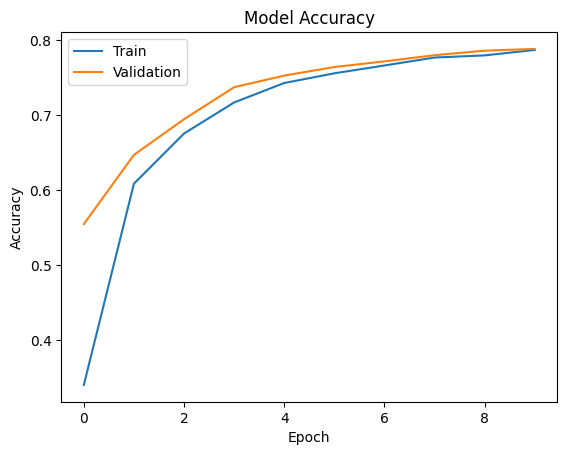

225/225 [==============================] - 5s 23ms/step - loss: 0.7284 - accuracy: 0.7879
Test Loss: 0.7284199595451355
Test Accuracy: 0.7879252433776855
225/225 [==============================] - 5s 21ms/step
F1 Score: 0.7083726257069468


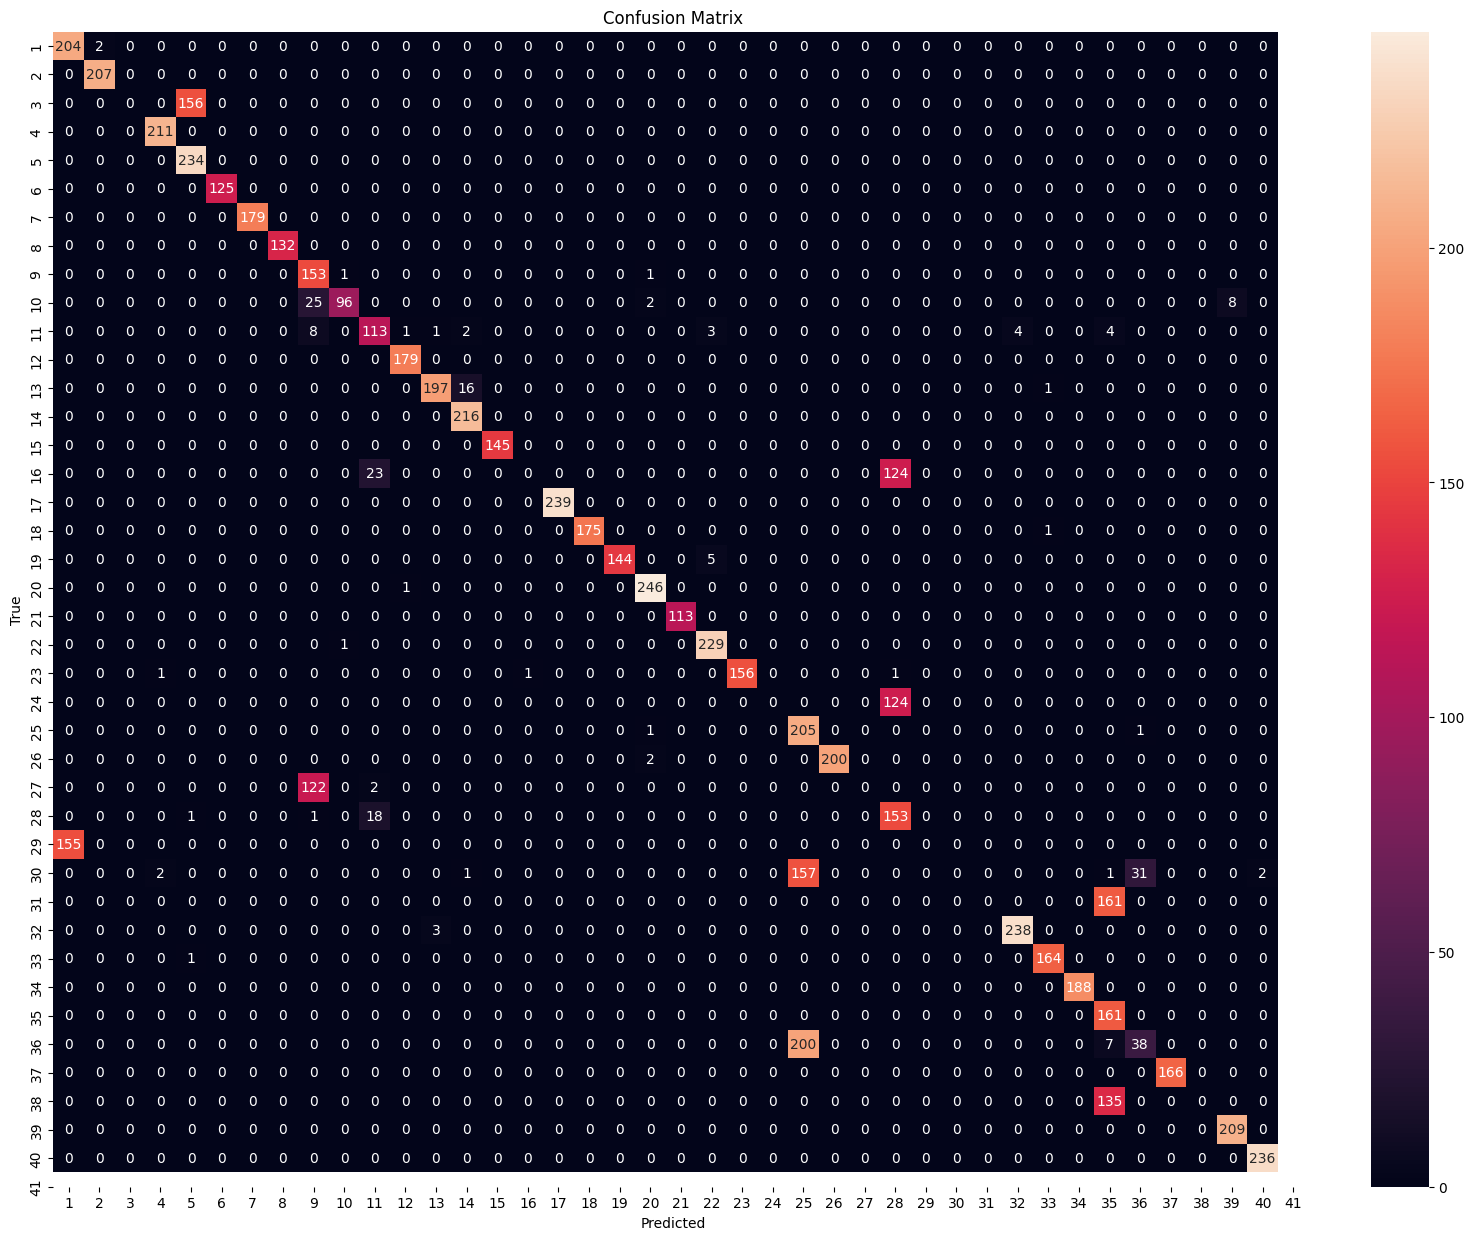

Classification Report:
              precision    recall  f1-score   support

           1       0.57      0.99      0.72       206
           2       0.99      1.00      1.00       207
           3       0.00      0.00      0.00       156
           4       0.99      1.00      0.99       211
           5       0.60      1.00      0.75       234
           6       1.00      1.00      1.00       125
           7       1.00      1.00      1.00       179
           8       1.00      1.00      1.00       132
           9       0.50      0.99      0.66       155
          10       0.98      0.73      0.84       131
          11       0.72      0.83      0.77       136
          12       0.99      1.00      0.99       179
          13       0.98      0.92      0.95       214
          14       0.92      1.00      0.96       216
          15       1.00      1.00      1.00       145
          16       0.00      0.00      0.00       147
          17       1.00      1.00      1.00       239
    

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
#new cnn hybrid model

import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
from keras.applications import Xception
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D, Dropout, Flatten, Input, Concatenate
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint
from sklearn.metrics import f1_score, classification_report, confusion_matrix
import seaborn as sns

# Function to count images in subfolders
def count_images_in_subfolders(input_folder):
    ar = []
    for folder_name in os.listdir(input_folder):
        input_subfolder = os.path.join(input_folder, folder_name)
        images = glob.glob(os.path.join(input_subfolder, '*'))
        print(f'The folder "{folder_name}" contains {len(images)} images.')
        ar.append(len(images))
    return ar

# Directory containing your dataset
dataset_dir = '/content/class40'

# Initialize lists to store images and labels
images = []
labels = []

# Loop through each class folder, read images, resize, and normalize
for class_folder in os.listdir(dataset_dir):
    label = int(class_folder)
    for image_name in os.listdir(os.path.join(dataset_dir, class_folder)):
        image = cv2.imread(os.path.join(dataset_dir, class_folder, image_name), cv2.IMREAD_GRAYSCALE)
        image = cv2.resize(image, (80, 80))
        image = image.astype('float32') / 255.0
        images.append(image)
        labels.append(label)

# Convert lists to numpy arrays and split the dataset into training and testing sets
images = np.array(images)
labels = np.array(labels)
x_train, x_test, y_train, y_test = train_test_split(images, labels, test_size=0.30, random_state=42)
x_train = x_train.reshape(x_train.shape[0], 80, 80, 1)
x_test = x_test.reshape(x_test.shape[0], 80, 80, 1)

# CNN model
cnn_input = Input(shape=(80, 80, 1))
cnn_conv1 = Conv2D(16, kernel_size=(3, 3), activation='relu')(cnn_input)
cnn_pool1 = MaxPooling2D((2, 2))(cnn_conv1)
cnn_conv2 = Conv2D(32, (3, 3), activation='relu')(cnn_pool1)
cnn_pool2 = MaxPooling2D(pool_size=(2, 2))(cnn_conv2)
cnn_conv3 = Conv2D(64, (3, 3), activation='relu')(cnn_pool2)
cnn_pool3 = MaxPooling2D(pool_size=(2, 2))(cnn_conv3)
cnn_flat = Flatten()(cnn_pool3)
cnn_dense = Dense(64, activation='relu')(cnn_flat)
cnn_output = Dense(41, activation='softmax')(cnn_dense)
cnn_model = Model(inputs=cnn_input, outputs=cnn_output)

# Xception model
xception_base = Xception(weights='imagenet', include_top=False, input_shape=(80, 80, 3))
xception_gap = GlobalAveragePooling2D()(xception_base.output)
xception_dense = Dense(128, activation='relu')(xception_gap)
xception_drop = Dropout(0.5)(xception_dense)
xception_output = Dense(41, activation='softmax')(xception_drop)
xception_model = Model(inputs=xception_base.input, outputs=xception_output)

# Combined model
combined_input = Concatenate()([cnn_model.output, xception_model.output])
combined_output = Dense(41, activation='softmax')(combined_input)
combined_model = Model(inputs=[cnn_model.input, xception_model.input], outputs=combined_output)

# Freeze the weights of the Xception model
for layer in xception_base.layers:
    layer.trainable = False

# Compile the combined model
combined_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = combined_model.fit([x_train, np.repeat(x_train.mean(axis=3)[..., np.newaxis], 3, -1)], to_categorical(y_train), validation_data=([x_test, np.repeat(x_test.mean(axis=3)[..., np.newaxis], 3, -1)], to_categorical(y_test)), epochs=10, batch_size=64)

# Plot training history
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Evaluate the model
test_loss, test_accuracy = combined_model.evaluate([x_test, np.repeat(x_test.mean(axis=3)[..., np.newaxis], 3, -1)], to_categorical(y_test))
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

# Make predictions
predictions = combined_model.predict([x_test, np.repeat(x_test.mean(axis=3)[..., np.newaxis], 3, -1)])
predicted_classes = np.argmax(predictions, axis=1)

# Calculate F1 score
f1 = f1_score(y_test, predicted_classes, average='macro')
print("F1 Score:", f1)

# Calculate confusion matrix
cm = confusion_matrix(y_test, predicted_classes)

# Plot confusion matrix with class labels starting from 1
plt.figure(figsize=(20, 15))
sns.heatmap(cm, annot=True, fmt="d", xticklabels=np.arange(1, 42), yticklabels=np.arange(1, 42))
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Generate classification report
report = classification_report(y_test, predicted_classes)
print("Classification Report:")
print(report)


# **#ADAM Batch size 128**

Epoch 1/10
131/131 [==============================] - 13s 62ms/step - loss: 3.4704 - accuracy: 0.2553 - val_loss: 3.2435 - val_accuracy: 0.5003
Epoch 2/10
131/131 [==============================] - 6s 49ms/step - loss: 3.0625 - accuracy: 0.5373 - val_loss: 2.8688 - val_accuracy: 0.5859
Epoch 3/10
131/131 [==============================] - 6s 49ms/step - loss: 2.7062 - accuracy: 0.6075 - val_loss: 2.5210 - val_accuracy: 0.6617
Epoch 4/10
131/131 [==============================] - 6s 49ms/step - loss: 2.3824 - accuracy: 0.6791 - val_loss: 2.2269 - val_accuracy: 0.7122
Epoch 5/10
131/131 [==============================] - 6s 49ms/step - loss: 2.0984 - accuracy: 0.7168 - val_loss: 1.9595 - val_accuracy: 0.7306
Epoch 6/10
131/131 [==============================] - 6s 49ms/step - loss: 1.8582 - accuracy: 0.7504 - val_loss: 1.7316 - val_accuracy: 0.7678
Epoch 7/10
131/131 [==============================] - 6s 49ms/step - loss: 1.6455 - accuracy: 0.7687 - val_loss: 1.5413 - val_accuracy: 0.779

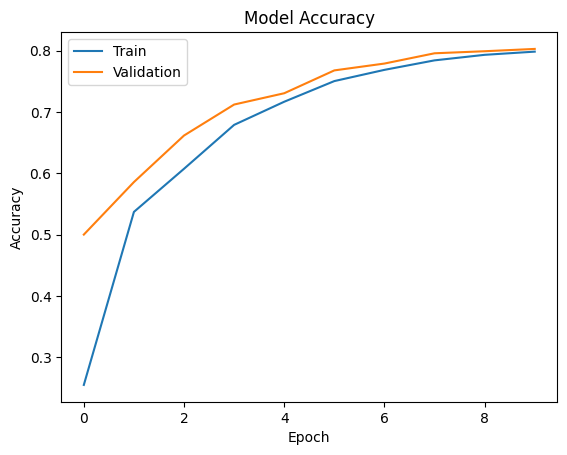

225/225 [==============================] - 2s 10ms/step - loss: 1.0931 - accuracy: 0.8028
Test Loss: 1.093131184577942
Test Accuracy: 0.8028444051742554
225/225 [==============================] - 3s 8ms/step
F1 Score: 0.7223300755515651


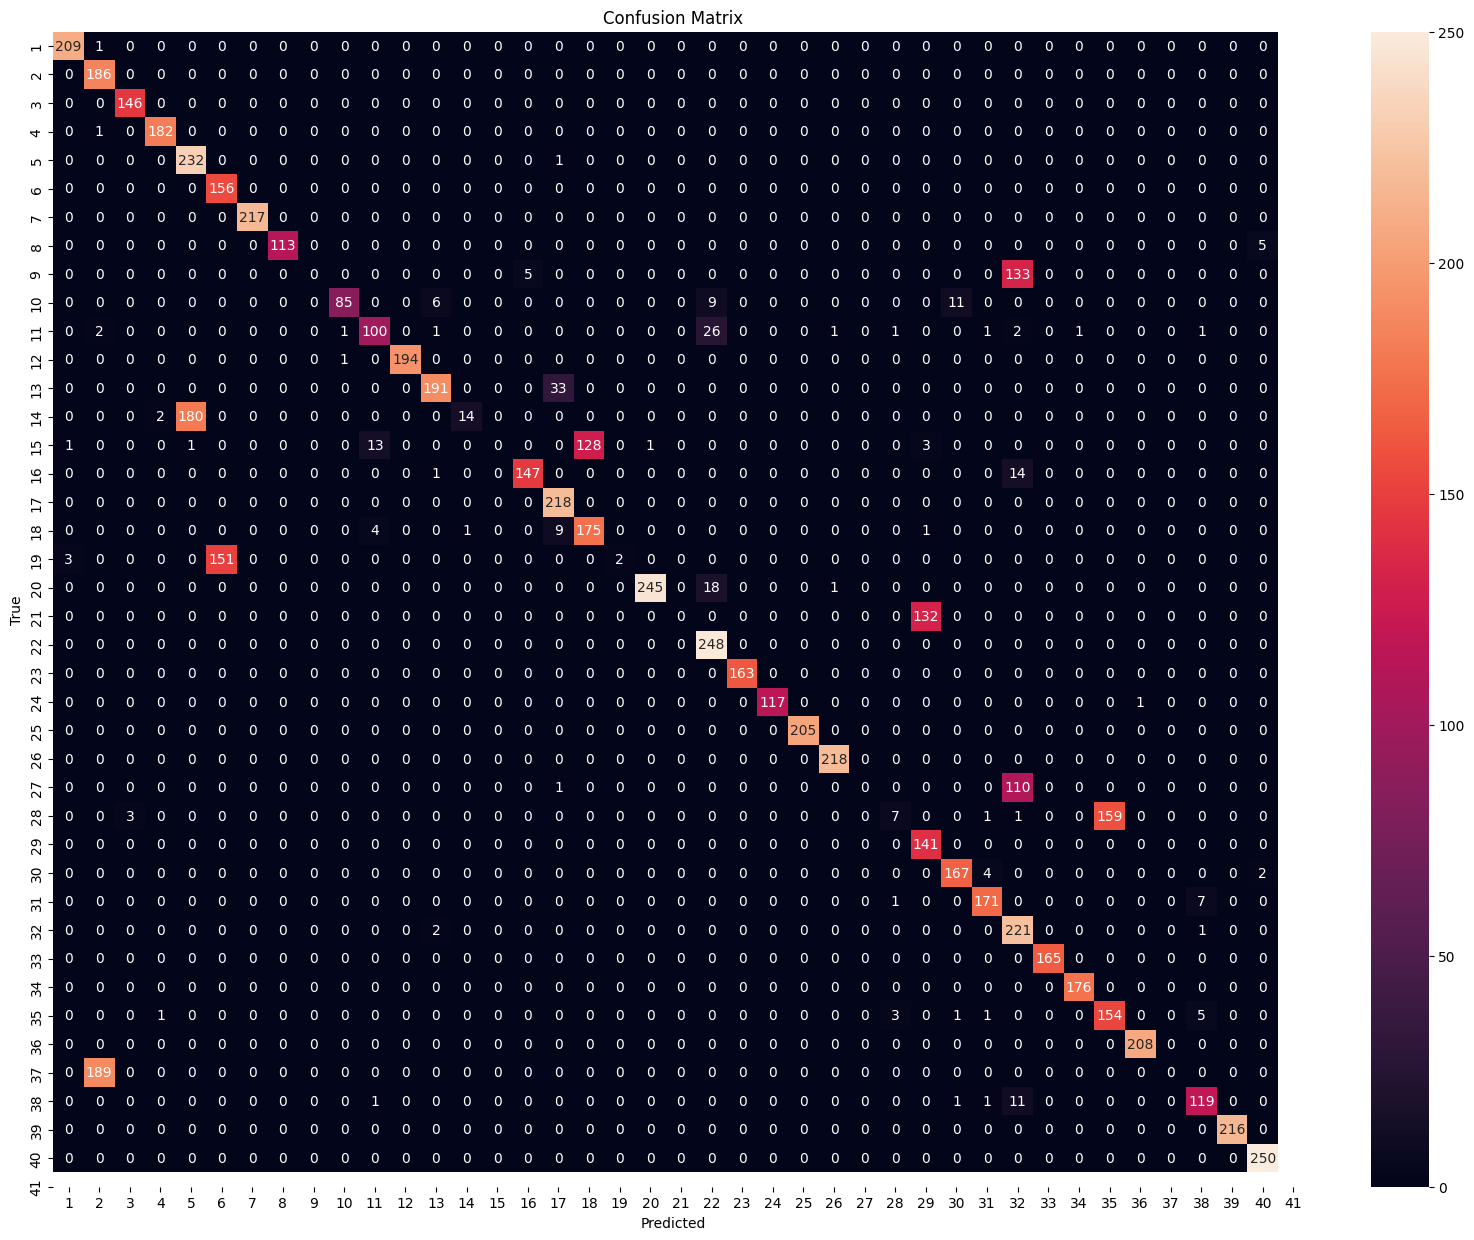

Classification Report:
              precision    recall  f1-score   support

           1       0.98      1.00      0.99       210
           2       0.49      1.00      0.66       186
           3       0.98      1.00      0.99       146
           4       0.98      0.99      0.99       183
           5       0.56      1.00      0.72       233
           6       0.51      1.00      0.67       156
           7       1.00      1.00      1.00       217
           8       1.00      0.96      0.98       118
           9       0.00      0.00      0.00       138
          10       0.98      0.77      0.86       111
          11       0.85      0.73      0.78       137
          12       1.00      0.99      1.00       195
          13       0.95      0.85      0.90       224
          14       0.93      0.07      0.13       196
          15       0.00      0.00      0.00       147
          16       0.97      0.91      0.94       162
          17       0.83      1.00      0.91       218
    

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:


import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
from keras.applications import Xception
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D, Dropout, Flatten, Input, Concatenate
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint
from sklearn.metrics import f1_score, classification_report, confusion_matrix
import seaborn as sns

# Function to count images in subfolders
def count_images_in_subfolders(input_folder):
    ar = []
    for folder_name in os.listdir(input_folder):
        input_subfolder = os.path.join(input_folder, folder_name)
        images = glob.glob(os.path.join(input_subfolder, '*'))
        print(f'The folder "{folder_name}" contains {len(images)} images.')
        ar.append(len(images))
    return ar

# Directory containing your dataset
dataset_dir = '/content/class40'

# Initialize lists to store images and labels
images = []
labels = []

# Loop through each class folder, read images, resize, and normalize
for class_folder in os.listdir(dataset_dir):
    label = int(class_folder)
    for image_name in os.listdir(os.path.join(dataset_dir, class_folder)):
        image = cv2.imread(os.path.join(dataset_dir, class_folder, image_name), cv2.IMREAD_GRAYSCALE)
        image = cv2.resize(image, (80, 80))
        image = image.astype('float32') / 255.0
        images.append(image)
        labels.append(label)

# Convert lists to numpy arrays and split the dataset into training and testing sets
images = np.array(images)
labels = np.array(labels)
x_train, x_test, y_train, y_test = train_test_split(images, labels, test_size=0.30, random_state=42)
x_train = x_train.reshape(x_train.shape[0], 80, 80, 1)
x_test = x_test.reshape(x_test.shape[0], 80, 80, 1)

# CNN model
cnn_input = Input(shape=(80, 80, 1))
cnn_conv1 = Conv2D(16, kernel_size=(3, 3), activation='relu')(cnn_input)
cnn_pool1 = MaxPooling2D((2, 2))(cnn_conv1)
cnn_conv2 = Conv2D(32, (3, 3), activation='relu')(cnn_pool1)
cnn_pool2 = MaxPooling2D(pool_size=(2, 2))(cnn_conv2)
cnn_conv3 = Conv2D(64, (3, 3), activation='relu')(cnn_pool2)
cnn_pool3 = MaxPooling2D(pool_size=(2, 2))(cnn_conv3)
cnn_flat = Flatten()(cnn_pool3)
cnn_dense = Dense(64, activation='relu')(cnn_flat)
cnn_output = Dense(41, activation='softmax')(cnn_dense)
cnn_model = Model(inputs=cnn_input, outputs=cnn_output)

# Xception model
xception_base = Xception(weights='imagenet', include_top=False, input_shape=(80, 80, 3))
xception_gap = GlobalAveragePooling2D()(xception_base.output)
xception_dense = Dense(128, activation='relu')(xception_gap)
xception_drop = Dropout(0.5)(xception_dense)
xception_output = Dense(41, activation='softmax')(xception_drop)
xception_model = Model(inputs=xception_base.input, outputs=xception_output)

# Combined model
combined_input = Concatenate()([cnn_model.output, xception_model.output])
combined_output = Dense(41, activation='softmax')(combined_input)
combined_model = Model(inputs=[cnn_model.input, xception_model.input], outputs=combined_output)

# Freeze the weights of the Xception model
for layer in xception_base.layers:
    layer.trainable = False

# Compile the combined model
combined_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = combined_model.fit([x_train, np.repeat(x_train.mean(axis=3)[..., np.newaxis], 3, -1)], to_categorical(y_train), validation_data=([x_test, np.repeat(x_test.mean(axis=3)[..., np.newaxis], 3, -1)], to_categorical(y_test)), epochs=10, batch_size=128)

# Plot training history
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Evaluate the model
test_loss, test_accuracy = combined_model.evaluate([x_test, np.repeat(x_test.mean(axis=3)[..., np.newaxis], 3, -1)], to_categorical(y_test))
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

# Make predictions
predictions = combined_model.predict([x_test, np.repeat(x_test.mean(axis=3)[..., np.newaxis], 3, -1)])
predicted_classes = np.argmax(predictions, axis=1)

# Calculate F1 score
f1 = f1_score(y_test, predicted_classes, average='macro')
print("F1 Score:", f1)

# Calculate confusion matrix
cm = confusion_matrix(y_test, predicted_classes)

# Plot confusion matrix with class labels starting from 1
plt.figure(figsize=(20, 15))
sns.heatmap(cm, annot=True, fmt="d", xticklabels=np.arange(1, 42), yticklabels=np.arange(1, 42))
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Generate classification report
report = classification_report(y_test, predicted_classes)
print("Classification Report:")
print(report)
